# EMAIL spam detection

## Imports + python version

In [1]:
import glob
import numpy as np
import email
from sklearn.model_selection import train_test_split
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly import tools
from sklearn.linear_model import LogisticRegression
from transformers import (
    AutoModelForSequenceClassification,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    TrainerCallback,
    Seq2SeqTrainer,
    AutoTokenizer,
    Trainer,
)
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitTrainer, SetFitModel
import evaluate
import numpy as np
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

import copy
import time
import pandas as pd
import torch
import transformers
import scienceplots

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!python3 --version

Python 3.10.12


## 1. Data preprocessing

### 1.1. Getting ham/spam sample

In [4]:
hamdata = glob.glob("ham/*")
spamdata = glob.glob("spam/*")

In [5]:
hamdata[0:10]

['ham/0001.ea7e79d3153e7469e7a9c3e0af6a357e',
 'ham/0002.b3120c4bcbf3101e661161ee7efcb8bf',
 'ham/0004.e8d5727378ddde5c3be181df593f1712',
 'ham/0007.c75188382f64b090022fa3b095b020b0',
 'ham/0008.20bc0b4ba2d99aae1c7098069f611a9b',
 'ham/0012.d354b2d2f24d1036caf1374dd94f4c94',
 'ham/0013.ff597adee000d073ae72200b0af00cd1',
 'ham/0014.532e0a17d0674ba7a9baa7b0afe5fb52',
 'ham/0015.a9ff8d7550759f6ab62cc200bdf156e7',
 'ham/0016.d82758030e304d41fb3f4ebbb7d9dd91']

In [6]:
spamdata[0:10]

['spam/00001.317e78fa8ee2f54cd4890fdc09ba8176',
 'spam/00002.9438920e9a55591b18e60d1ed37d992b',
 'spam/00003.590eff932f8704d8b0fcbe69d023b54d',
 'spam/00004.bdcc075fa4beb5157b5dd6cd41d8887b',
 'spam/00005.ed0aba4d386c5e62bc737cf3f0ed9589',
 'spam/00006.3ca1f399ccda5d897fecb8c57669a283',
 'spam/00007.acefeee792b5298f8fee175f9f65c453',
 'spam/00008.ccf927a6aec028f5472ca7b9db9eee20',
 'spam/00009.1e1a8cb4b57532ab38aa23287523659d',
 'spam/00010.2558d935f6439cb40d3acb8b8569aa9b']

In [7]:
def get_email_content(email_path: str) -> str:
    """
    Description:

    This function extracts the content from an email file located at the specified path. 

    # Args:

    * `email_path (str)`: The path to the email file.

    Returns:

    * `str`: The extracted email content as a string.

    Raises:

    * `FileNotFoundError`: If the email file is not found at the given path.
    * `IOError`: If there is an error reading the email file.

    # Example:

    >>> content = get_email_content("/path/to/email.eml")\n
    >>> print(content)
    """
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload()
    except Exception as e:
        print(e)
        
        
def get_email_content_bulk(email_paths: list[str]) -> list[str]:
    """
    Description:

    This function extracts the content from multiple email files specified in a list of paths.

    # Args:

    * `email_paths (list[str])`: A list of paths to email files.

    Returns:

    * `list[str]`: A list containing the extracted content of each email file. 

    Raises:

    * `FileNotFoundError`: If any email file is not found at the given path.
    * `IOError`: If there is an error reading any email file.

    # Example:

    >>> email_paths = ["/path/to/email1.eml", "/path/to/email2.eml"]\n
    >>> contents = get_email_content_bulk(email_paths)\n
    >>> print(contents)
    """
    email_contents = [get_email_content(o) for o in email_paths]
    return email_contents

In [8]:
ham_path = [hamdata]
spam_path = [spamdata]

#### Getting ham samples

In [9]:
ham_sample = np.asarray([train_test_split(o, train_size=0.7, random_state=52, shuffle=True) for o in ham_path], dtype="object")

In [10]:
ham_train = np.array([])
ham_test = np.array([])
for o in ham_sample:
    ham_train = np.concatenate((ham_train,o[0]),axis=0)
    ham_test = np.concatenate((ham_test,o[1]),axis=0)

In [11]:
ham_train.shape, ham_test.shape

((1776,), (762,))

In [12]:
ham_train[0:10]

array(['ham/1166.8a9dbee6ac67226f58a80c0993a700e2',
       'ham/0066.dcf72ba90be7570f2f7edab45b23ae36',
       'ham/1644.ba26918a1837fcadae2327adc12a797d',
       'ham/1707.5c6277e057c0b3238b03d60de3109e8e',
       'ham/1504.f77b2dc9ad8c875d8edc67b180e2f878',
       'ham/2330.854fdf89bd1ad6013aa5188ca205f6ba',
       'ham/1241.7bc7f4b48ba3328fe2ef672da8c9930e',
       'ham/2021.adcaa7be43b7bdc9828ada336c0eb7ec',
       'ham/1813.c86ae674674567c5779cfb7a30385e45',
       'ham/0233.8ee5f381dff013a0ccac9a01ac2d2976'], dtype='<U41')

In [13]:
ham_test[0:10]

array(['ham/1169.b4991cd8416f8f9c29bf9e5359f667f5',
       'ham/0397.bdea17c7f90068a763d191914770f6d6',
       'ham/1887.884e4c55dd2c7579be9b0986190a1426',
       'ham/1950.6efb69934715d6e12d3ce0cb4e8e4782',
       'ham/1136.b12b9479134d3bab39dd5101720b062f',
       'ham/0944.17f20b8ad4ea51e366873fa551ad20da',
       'ham/0819.337934ad4a28fb473915e323d3866edc',
       'ham/0329.0479ba224116953d0c94c30edbc91b55',
       'ham/0768.42d3db0f0b763a75183afd06f5db8ce5',
       'ham/1752.5bcdd9205f59d95e025a2896a38ee2bb'], dtype='<U41')

#### Getting spam samples

In [14]:
spam_sample = np.asarray([train_test_split(o) for o in spam_path], dtype = "object")

In [15]:
spam_train = np.array([])
spam_test = np.array([])
for o in spam_sample:
    spam_train = np.concatenate((spam_train,o[0]),axis=0)
    spam_test = np.concatenate((spam_test,o[1]),axis=0)

In [16]:
spam_train.shape, spam_test.shape

((1047,), (350,))

In [17]:
spam_train[0:10]

array(['spam/00079.7a1b9cd54acec8774ef833df17206630',
       'spam/00178.2dbe6aa90dc38758c946170ff92ec8e8',
       'spam/00469.d2c0c55b686454f38eee312c5e190816',
       'spam/00029.cc0c62b49c1df0ad08ae49a7e1904531',
       'spam/00339.5982235f90972c2cf5ecaaf775dace46',
       'spam/01064.50715ffeb13446500895836b77fcee09',
       'spam/00885.6f8bc5aec58114e2d8ae91f3d1b464fc',
       'spam/00206.434bca9a9918edbdb04b93f6618adf90',
       'spam/00771.e33fd0de6b6c763a697a4fba307091d0',
       'spam/00769.b4477686a6ab2b52370e3f671ce9a016'], dtype='<U43')

In [18]:
spam_test[0:10]

array(['spam/00464.d2f719c667d192af860572b1c858cc11',
       'spam/01047.2e01ca2cd13baa8ba6fe1429f39f85de',
       'spam/00321.00c19304d06d2e9fd068873434f1297e',
       'spam/00972.5290463cd76d76c7dc9e2d2fb88cb8d1',
       'spam/01296.34052422109f131a8b1fb59d1d42f899',
       'spam/00358.ccfcaa5984dc5db979ba41e0fcee87c3',
       'spam/01344.43dbbbac0d006790dd696123d455f5b9',
       'spam/01222.86831c8b346812d6526d6ddc7d3eb185',
       'spam/00683.41038a20d4763e8042a811a03612bae4',
       'spam/00504.0a250a54cc14771c55105d9cfdf39151'], dtype='<U43')

Creating x_train, y_train (paths to containing texts), x_test, y_test (corresponding labels to contents in x_train y_train respectively)

In [19]:
ham_train_label = [0]*ham_train.shape[0]
spam_train_label = [1]*spam_train.shape[0]
x_train = np.concatenate((ham_train,spam_train))
y_train = np.concatenate((ham_train_label,spam_train_label))

In [20]:
x_train

array(['ham/1166.8a9dbee6ac67226f58a80c0993a700e2',
       'ham/0066.dcf72ba90be7570f2f7edab45b23ae36',
       'ham/1644.ba26918a1837fcadae2327adc12a797d', ...,
       'spam/00173.6f5baeeaeb9b1c1ac4b9527e948828db',
       'spam/00486.7f5cde6ad9f34dcbe56a1fd73138b351',
       'spam/00446.dbbe3d81a19420ba8c135ac7f044319c'], dtype='<U43')

In [21]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [22]:
ham_test_label = [0]*ham_test.shape[0]
spam_test_label = [1]*spam_test.shape[0]
x_test = np.concatenate((ham_test,spam_test))
y_test = np.concatenate((ham_test_label,spam_test_label))

In [23]:
x_test

array(['ham/1169.b4991cd8416f8f9c29bf9e5359f667f5',
       'ham/0397.bdea17c7f90068a763d191914770f6d6',
       'ham/1887.884e4c55dd2c7579be9b0986190a1426', ...,
       'spam/00023.5bec0fc32cfc42c9cc5c941d94258567',
       'spam/01206.b769233047fc696cc02ece9629190b42',
       'spam/00392.f494d12cb0d5daaead0e7f10f8afaef1'], dtype='<U43')

In [24]:
y_test

array([0, 0, 0, ..., 1, 1, 1])

Shuffle data we got

In [25]:
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

In [26]:
train_shuffle_index

array([1708,   80,  837, ..., 1753,  886, 1711])

In [27]:
test_shuffle_index

array([826, 448, 800, ...,   0,   4, 977])

In [28]:
x_train = x_train[train_shuffle_index]
y_train= y_train[train_shuffle_index]

In [29]:
x_train

array(['ham/1135.55ab9518e8b987f67ed8b5b85e8543e8',
       'ham/0589.8646984ed76a8df2811750d151f56b1e',
       'ham/2299.c928b7bad131d78430d84f5518fc6c59', ...,
       'ham/0996.a6ea93af44bc21fb704aecfd1bc4d57a',
       'ham/2179.8f1ee5b4ce8900e6d9992fa232c9286b',
       'ham/2163.0ccb16a07546a6528885233e0a7ddfd3'], dtype='<U43')

In [30]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

In [32]:
x_test

array(['spam/00821.b64c27e913e301f038ebfaa433f16f35',
       'ham/0091.3bdd7b578973ee005733480a8b6c9b54',
       'spam/01145.a34477ade6db9376e4f8ccbfa8607881', ...,
       'ham/1169.b4991cd8416f8f9c29bf9e5359f667f5',
       'ham/1136.b12b9479134d3bab39dd5101720b062f',
       'spam/00555.75544646fbe1fd3cb3717fb02a72e824'], dtype='<U43')

In [33]:
y_test

array([1, 0, 1, ..., 0, 0, 1])

Getting train and test texts

In [34]:
x_train = get_email_content_bulk(x_train)
x_test = get_email_content_bulk(x_test)

In [35]:
x_train[0:10]

["Hi,\n\n=09I made a spec file for it some weeks ago, maybe it can be included in =\nfresh.=20\nIf not,  at least you can use it...\n\nI'm attaching it here...\n\nHope it might be some use for you, does the trick for me. Might be an old=\n=20\nversion though, but should still work\n\nNick\n\n\n\n\nOn Wednesday 04 September 2002 21:00, Doug Stewart wrote:\n> I've noted that there are packaged versions of\n> Blackbox and hackedbox available from FreshRPMs.  What\n> about FluxBox? http://fluxbox.sf.net\n>\n> I'd certainly enjoy a packaged version, since its\n> creators seem hesitant to provide .rpms (.debs, yes,\n> but no .rpms).\n>\n> .Doug\n>\n> __________________________________________________\n> Do You Yahoo!?\n> Yahoo! Finance - Get real-time stock quotes\n> http://finance.yahoo.com\n>\n> _______________________________________________\n> RPM-List mailing list <RPM-List@freshrpms.net>\n> http://lists.freshrpms.net/mailman/listinfo/rpm-list\n",
 '\nWhy so fast?  Normal terminal veloc

In [36]:
x_test[0:10]

[None,
 'On Thu, 2002-08-29 at 19:27, Barry Dexter A. Gonzaga wrote:\n> On Thu, Aug 29, 2002 at 05:10:47PM -0400, Larry W. Virden wrote:\n> > I am wondering whether there\'s a way that I can use sitescooper and/or plucker\n> > or some other free utility to convert word documents into something a bit\n> > more palmos friendly?\n> \n> \tYou could try antiword (http://www.winfield.demon.nl/linux/).\n> It\'s consoled based and converts word 6+ docs to text and some images to\n> postscript and png.\n\nalso there\'s catdoc and wv for Word --> text conversions.  actually, wv\nconsists of wvWare, which as the manpage says "converts word documents\ninto other formats such as PS, PDF, HTML, LaTeX, DVI, ABW".  HTML would\nprobably be the best format for use with Plucker/SiteScooper, depending\non how good the DOC --> HTML conversion is.  i haven\'t used either in\nover a year as AbiWord or OpenOffice work well enough.  (prefer AbiWord\nfor it\'s light-weight size, but OpenOffice has the better DO

Removing nullables

In [37]:
def remove_null(datas: list[str],labels: list[int]) -> tuple[list[str], list[int]]:
    """
    Description: Removes elements from both lists where the corresponding label is None.

    # Args:
        datas (list[str]): A list of strings.
        labels (list[int]): A list of integers with the same length as `datas`.

    Returns:
        tuple[list[str], list[int]]: A tuple containing the updated lists of strings and labels.

    Raises:
        ValueError: If the lengths of `datas` and `labels` are not equal.

    # Example:

    >>> datas = ["apple", "banana", None, "orange"]
    >>> labels = [1, 1, 0, 1]
    >>> remove_null(datas, labels)
    (['apple', 'banana', 'orange'], [1, 1, 1])
"""
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

In [38]:
x_train,y_train = remove_null(x_train,y_train)
x_test,y_test = remove_null(x_test,y_test)

### 1.2 Cleaning up with NLTK

In [39]:
def remove_hyperlink(word: str) -> str:
    """
    Description: Removes hyperlinks from a given string.

    # Args:
        word (str): The string potentially containing hyperlinks.

    Returns:
        str: The string with hyperlinks removed.

    # Example:

    >>> remove_hyperlink("Check out https://www.example.com!")
    'Check out !'
    """
    return  re.sub(r"http\S+", "", word)

def to_lower(word: str) -> str:
    """
    Description: Converts a string to lowercase.

    # Args:
        word (str): The string to convert.

    Returns:
        str: The lowercase version of the string.

    # Example:

    >>> to_lower("Hello WORLD")
    'hello world'
    """
    result = word.lower()
    return result

def remove_number(word: str) -> str:
    """
    Description: Removes numbers from a string.

    # Args:
        word (str): The string potentially containing numbers.

    Returns:
        str: The string with numbers removed.

    # Example:

    >>> remove_number("This is year 2023")
    'This is year '
    """
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word: str) -> str:
    """
    Description: Removes punctuation marks from a string.

    # Args:
        word (str): The string potentially containing punctuation.

    Returns:
        str: The string with punctuation removed.

    # Example:

    >>> remove_punctuation("Hello, world!")
    'Hello world'
    """
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word: str) -> str:
    """
    Description: Removes leading and trailing whitespaces from a string.

    # Args:
        word (str): The string potentially containing whitespaces.

    Returns:
        str: The string with leading and trailing whitespaces removed.

    # Example:

    >>> remove_whitespace("  hello   ")
    'hello'
    """
    result = word.strip()
    return result

def replace_newline(word: str) -> str:
    """
    Description: Replaces newline characters with spaces in a string.

    # Args:
        word (str): The string potentially containing newline characters.

    Returns:
        str: The string with newline characters replaced by spaces.

    # Example:

    >>> replace_newline("Hello\nWorld")
    'Hello World'
    """
    return word.replace('\n','')

def clean_up_pipeline(sentence: str) -> str:
    """
    Description: Applies a series of cleaning operations to a sentence.\n
    For now:
    >>> remove_hyperlink()
    >>> replace_newline()
    >>> to_lower()
    >>> remove_number()
    >>> remove_punctuation()
    >>> remove_whitespace()

    # Args:
        sentence (str): The sentence to clean.

    Returns:
        str: The cleaned sentence.

    # Example:

    >>> clean_up_pipeline("  HeLlO, wOrLd! 2023  ")
    'hello world'
    """ 
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [40]:
x_train = [clean_up_pipeline(o) for o in x_train]
x_test = [clean_up_pipeline(o) for o in x_test]

In [41]:
x_train[0:10]

['hii made a spec file for it some weeks ago maybe it can be included in freshif not  at least you can use itim attaching it herehope it might be some use for you does the trick for me might be an oldversion though but should still worknickon wednesday  september   doug stewart wrote ive noted that there are packaged versions of blackbox and hackedbox available from freshrpms  what about fluxbox  id certainly enjoy a packaged version since its creators seem hesitant to provide rpms debs yes but no rpms doug  do you yahoo yahoo finance  get realtime stock quotes   rpmlist mailing list rpmlistfreshrpmsnet',
 'why so fast  normal terminal velocity is much slower original message from forkadminxentcom mailtoforkadminxentcom on behalf of bitbitchmagnesiumnet sent sunday september    am to robert harley cc forkexamplecom subject re the big jump    so uh would this qualify for the darwin awards if he doesnt make it  freaking french people     bb rh today a french officer called michel fournie

In [42]:
x_test[0:10]

['on thu  at  barry dexter a gonzaga wrote on thu aug   at pm  larry w virden wrote  i am wondering whether theres a way that i can use sitescooper andor plucker  or some other free utility to convert word documents into something a bit  more palmos friendly  \tyou could try antiword  its consoled based and converts word  docs to text and some images to postscript and pngalso theres catdoc and wv for word  text conversions  actually wvconsists of wvware which as the manpage says converts word documentsinto other formats such as ps pdf html latex dvi abw  html wouldprobably be the best format for use with pluckersitescooper dependingon how good the doc  html conversion is  i havent used either inover a year as abiword or openoffice work well enough  prefer abiwordfor its lightweight size but openoffice has the better doc importerdont know which of these are better or worse than the other but ifigure the more the merrier  you could also try openoffice andor abiword if you have x installe

In [43]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [44]:
x_train = [word_tokenize(o) for o in x_train]
x_test = [word_tokenize(o) for o in x_test]

In [45]:
def remove_stop_words(words: list[str]) -> list[str]:
    """
    Description: Removes stop words from a list of stop words from sklearn.

    # Args:
        words (list[str]): A list of words.

    Returns:
        list[str]: The list of words with stop words removed.

    # Example:

    >>> remove_stop_words(["the", "quick", "brown", "fox"])
    ['quick', 'brown', 'fox']
    """
    result = [i for i in words if i not in sklearn_stop_words]
    return result

def word_stemmer(words: list[str]) -> list[str]:
    """
    Description: Applies stemming to a list of words.

    # Args:
        words (list[str]): A list of words.

    Returns:
        list[str]: The list of stemmed words.

    # Example:

    >>> word_stemmer(["running", "jumps", "jumped"])
    ['run', 'jump', 'jump']
    """
    return [stemmer.stem(o) for o in words]

def word_lemmatizer(words: list[str]) -> list[str]:
    """
    Description: Applies lemmatization to a list of words.

    # Args:
        words (list[str]): A list of words.

    Returns:
        list[str]: The list of lemmatized words.

    # Example:

    >>> word_lemmatizer(["running", "better", "best"])
    ['run', 'good', 'good'] 
    """
    return [lemmatizer.lemmatize(o) for o in words]

def clean_token_pipeline(words: list[str]) -> list[str]:
    """
    Description: Applies a series of cleaning operations to a list of tokens.

    # Args:
        words (list[str]): A list of tokens.

    Returns:
        list[str]: The cleaned list of tokens.

    # Example:

    >>> clean_token_pipeline([" The ", "quick!", "ran.", "2023"])
    ['quick', 'ran']
    """
    cleaning_utils = [remove_stop_words,
                      word_lemmatizer]
    for o in cleaning_utils:
        words = o(words)
    return words

In [46]:
x_train = [clean_token_pipeline(o) for o in x_train]
x_test = [clean_token_pipeline(o) for o in x_test]

In [47]:
x_train = [" ".join(o) for o in x_train]
x_test = [" ".join(o) for o in x_test]

In [48]:
x_train[0:10]

['hii spec file week ago maybe included freshif use itim attaching herehope use doe trick oldversion worknickon wednesday september doug stewart wrote ive noted packaged version blackbox hackedbox available freshrpms fluxbox id certainly enjoy packaged version creator hesitant provide rpm deb yes rpm doug yahoo yahoo finance realtime stock quote rpmlist mailing list rpmlistfreshrpmsnet',
 'fast normal terminal velocity slower original message forkadminxentcom mailtoforkadminxentcom behalf bitbitchmagnesiumnet sent sunday september robert harley cc forkexamplecom subject big jump uh qualify darwin award doesnt make freaking french people bb rh today french officer called michel fournier supposed getin rh metre tall helium balloon ride edge space km rh altitude jump fall minute andreach rh speed mach hope open parachute manually atthe rh end automatic backup second rh ground opened rh r rh obquote rh vederò si averò si grossi li coglioni come ha il difranza rh let ive got ball king franc

In [49]:
x_test[0:10]

['thu barry dexter gonzaga wrote thu aug pm larry w virden wrote wondering there way use sitescooper andor plucker free utility convert word document bit palmos friendly try antiword consoled based convert word doc text image postscript pngalso there catdoc wv word text conversion actually wvconsists wvware manpage say convert word documentsinto format p pdf html latex dvi abw html wouldprobably best format use pluckersitescooper dependingon good doc html conversion havent used inover year abiword openoffice work prefer abiwordfor lightweight size openoffice better doc importerdont know better worse ifigure merrier try openoffice andor abiword x installedabiword support exporting palmdoc pdb aspalmosfriendly triedneeded listedthere save dialog boxwine crossover office support wordviewer free download microsoft didnt year ago wheni tried word viewer used day convertword doc word display word doc copy paste text formatting word onlyversion word anyways little nostalgia dont window machin

## 2. Visualization

In [50]:
def plot_wordcloud(text: str, mask: str=None, max_words: int=200, max_font_size: int=100, figure_size: tuple[int,int]=(24.0,16.0), 
                   title: str = None, title_size: int=40, image_color: str=False) -> None:
    """
    Description: Generates and displays a word cloud image.

    # Args:
        text (str): The text to generate the word cloud from.
        mask (str, optional): Path to an image mask. Defaults to None.
        max_words (int, optional): Maximum number of words in the cloud. Defaults to 200.
        max_font_size (int, optional): Maximum font size for words. Defaults to 100.
        figure_size (tuple[int,int], optional): Size of the figure. Defaults to (24.0,16.0).
        title (str, optional): Title for the word cloud. Defaults to None.
        title_size (int, optional): Font size of the title. Defaults to 40.
        image_color (str, optional): If True, the image will be converted to grayscale. Defaults to False.

    Returns:
        None

    # Example:

    >>> plot_wordcloud("This is an example text for word cloud generation")
    """
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [51]:
spam_train_index = [i for i,o in enumerate(y_train) if o == 1]
non_spam_train_index = [i for i,o in enumerate(y_train) if o == 0]

In [52]:
spam_train_index[0:10]

[5, 8, 15, 16, 18, 19, 22, 23, 28, 35]

In [53]:
non_spam_train_index[0:10]

[0, 1, 2, 3, 4, 6, 7, 9, 10, 11]

In [54]:
spam_email = np.array(x_train)[spam_train_index]
non_spam_email = np.array(x_train)[non_spam_train_index]

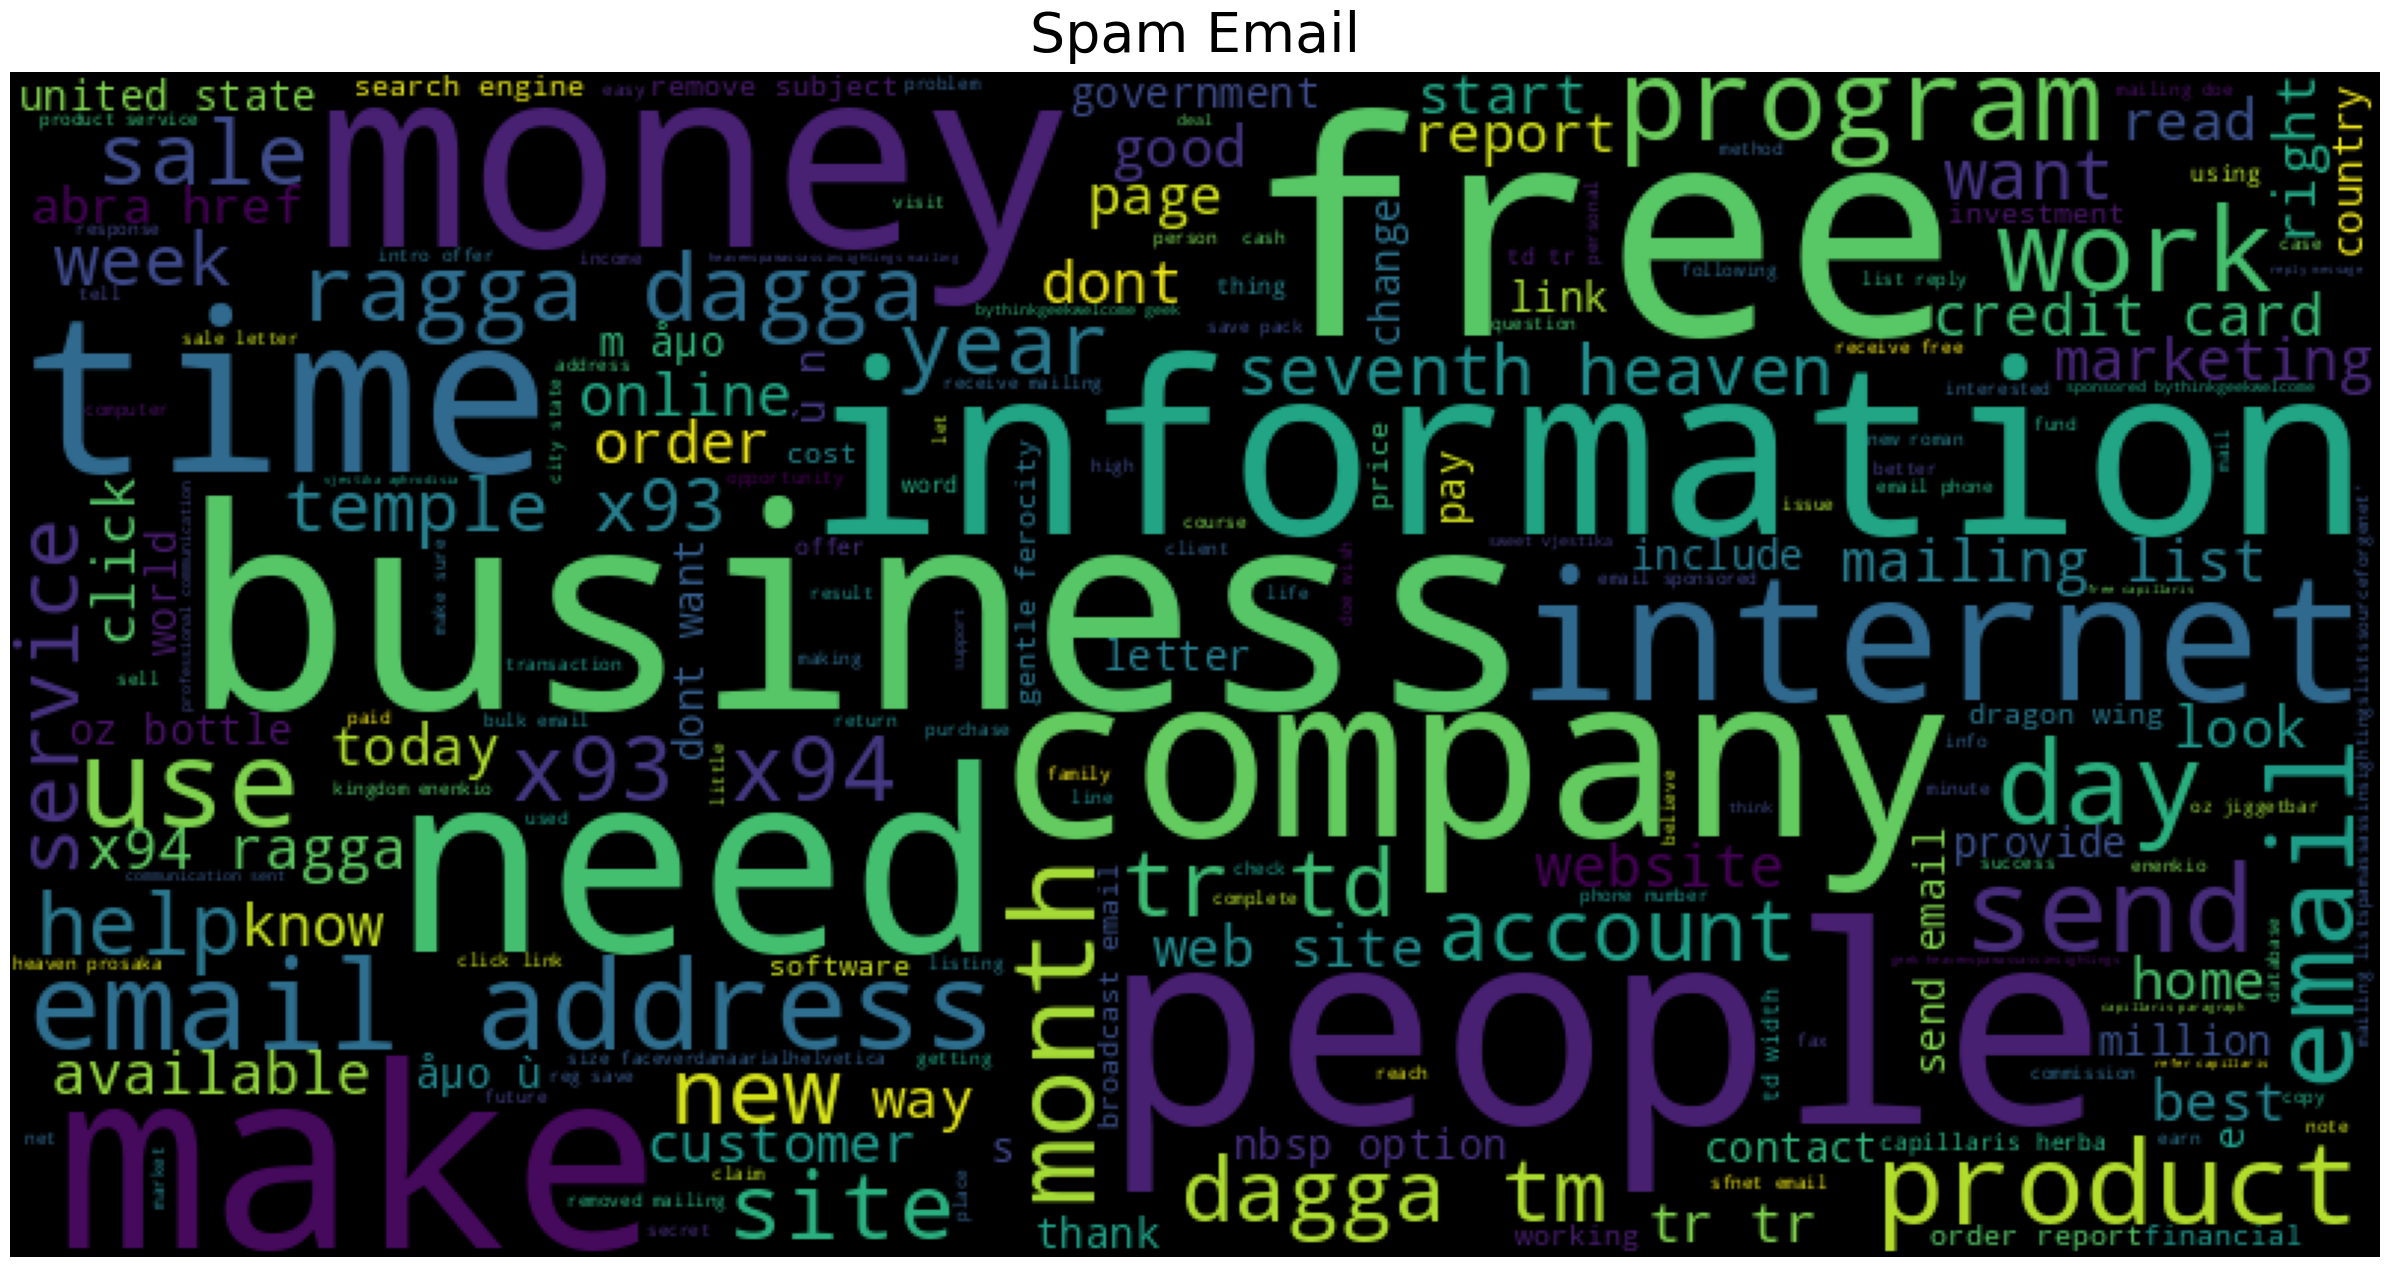

In [55]:
plot_wordcloud(spam_email,title = 'Spam Email')

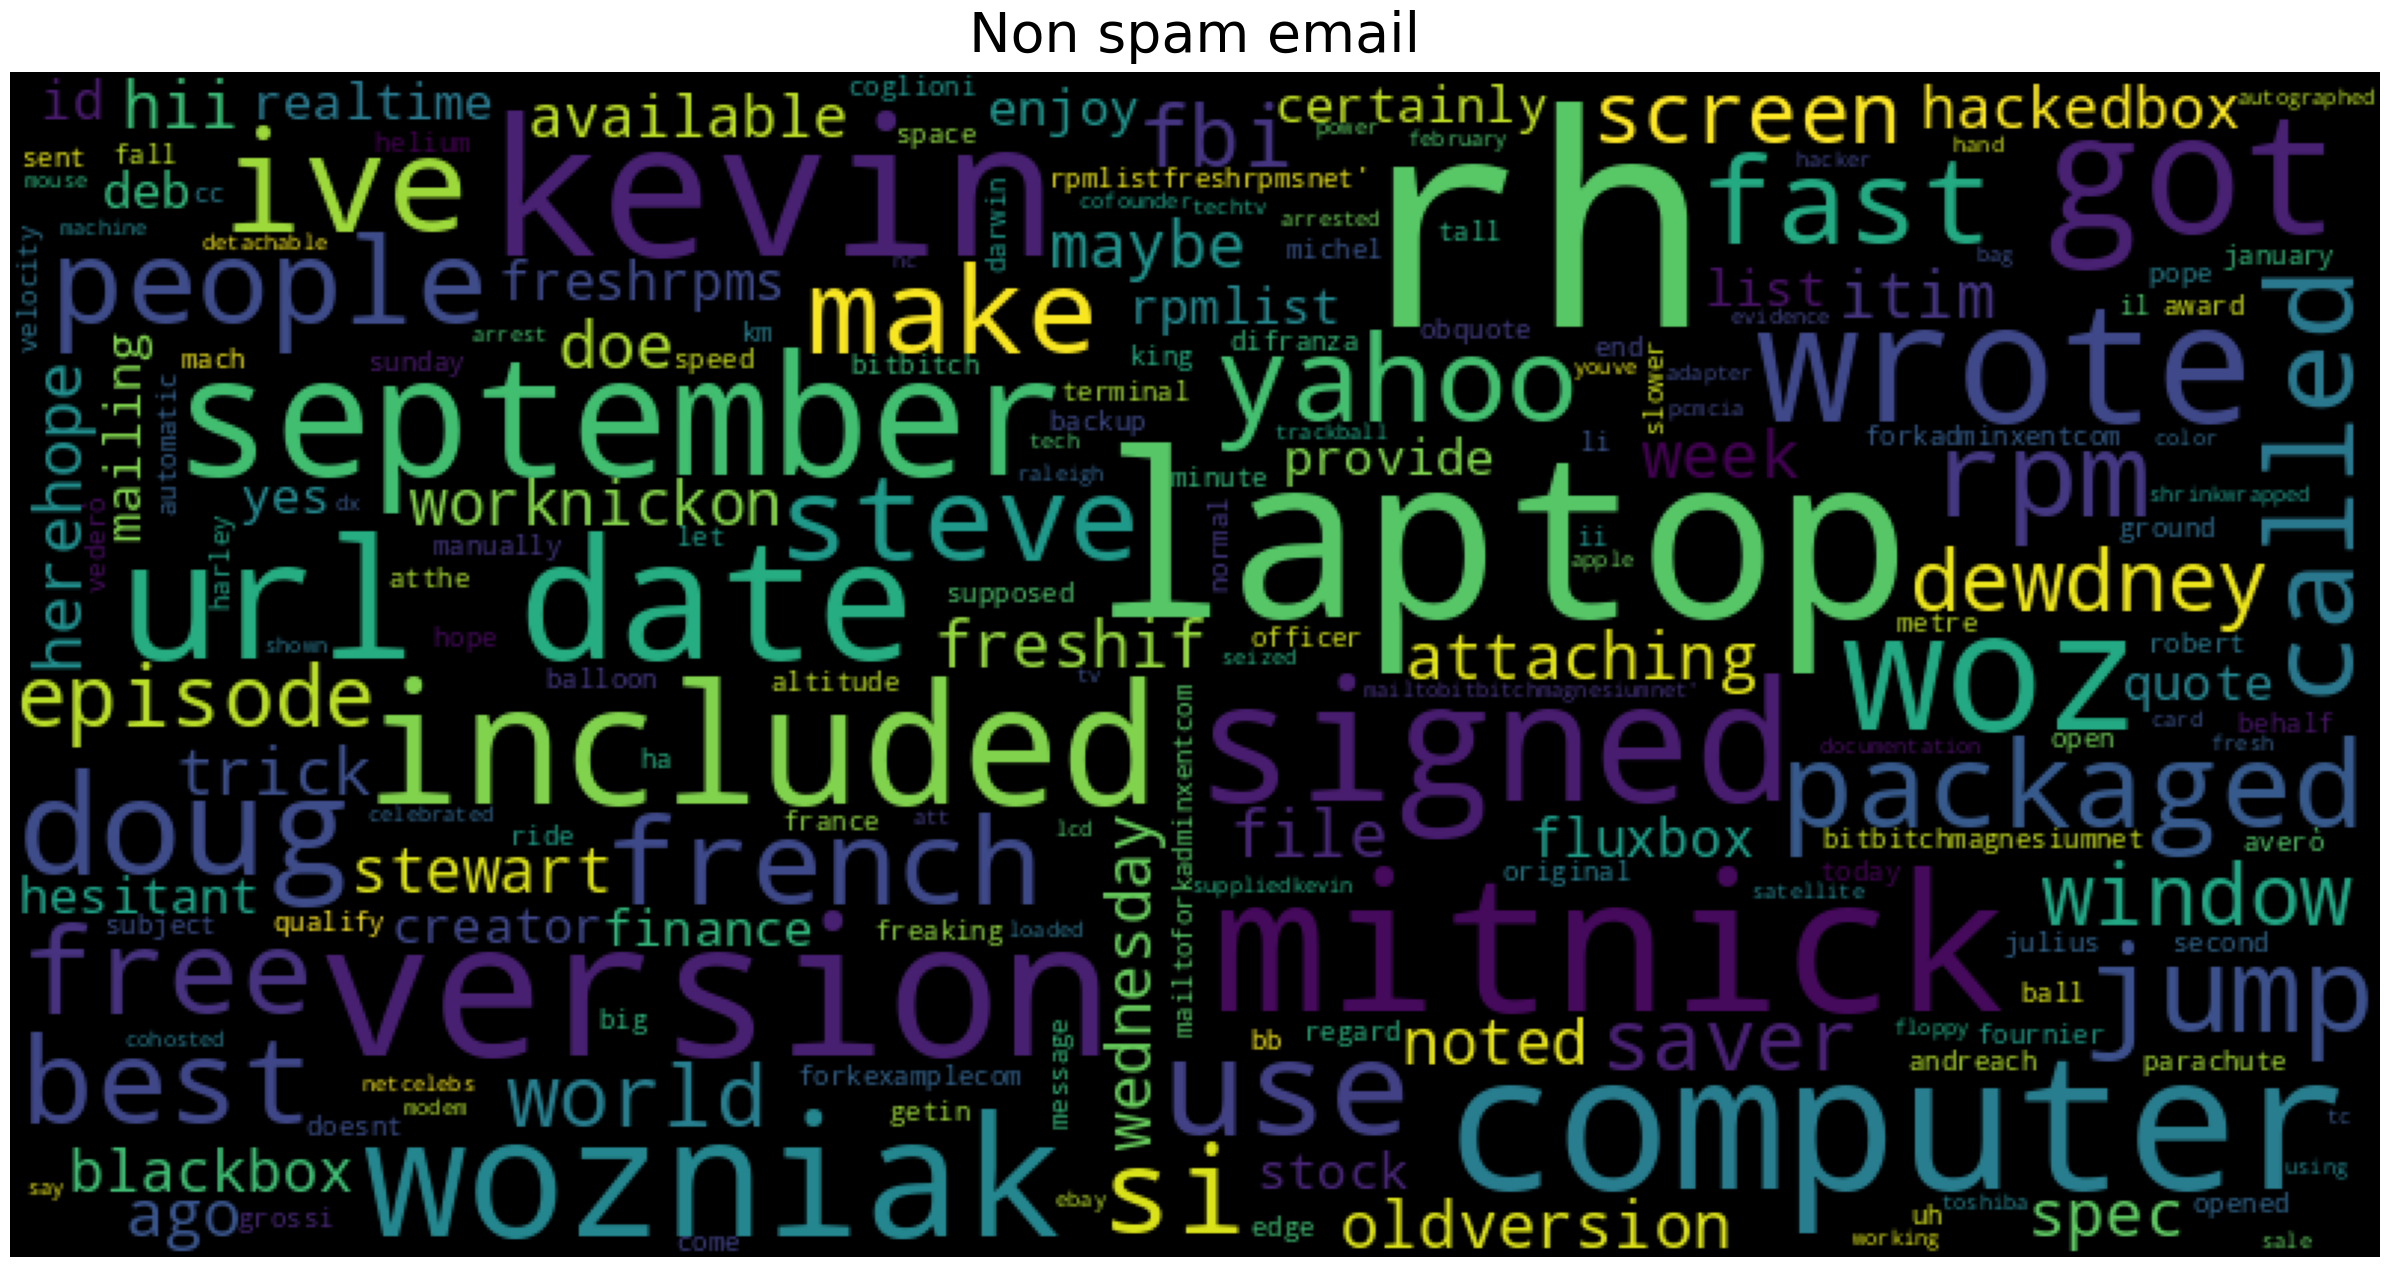

In [56]:
plot_wordcloud(non_spam_email, title="Non spam email")

In [57]:
## custom function for ngram generation ##
def generate_ngrams(text: str, n_gram: int=1) -> list[str]:
    """
    Description: Generates n-grams from a given text.

    # Args:
        text (str): The text to generate n-grams from.
        n_gram (int, optional): The value of n for the n-grams. Defaults to 1.

    Returns:
        list[str]: A list of n-grams. 

    # Example:

    >>> generate_ngrams("This is a sentence", 2)
    ['This is', 'is a', 'a sentence'] 
    """
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df: pd.DataFrame, color: str)-> go.Bar:
    """
    Description: Creates a horizontal bar chart using plotly.

    # Args:
        df (pd.DataFrame): The dataframe containing the data.
        color (str): The color for the bars.

    Returns:
        go.Bar: The plotly bar chart object.

    # Example:

    >>> horizontal_bar_chart(data, "blue")
    """
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [58]:
def visualize_in_bar_chart(word_count: int=1) -> None:
    """
    Description: Visualizes word counts in a bar chart.

    # Args:
        word_count (int, optional): The number of words to include in the chart. Defaults to 1.

    Returns:
        None 

    # Example:

    >>> visualize_in_bar_chart(20) 
    """
    ## Get the bar chart from sincere questions ##
    freq_dict = defaultdict(int)
    for sent in non_spam_email:
        for word in generate_ngrams(sent,word_count):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')

    ## Get the bar chart from insincere questions ##
    freq_dict = defaultdict(int)
    for sent in spam_email:
        for word in generate_ngrams(sent,word_count):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace1 = horizontal_bar_chart(fd_sorted.head(20), 'blue')

    # Creating two subplots
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent words of non spam email", 
                                              "Frequent words of spam email"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    fig['layout'].update(height=600, width=800, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')

In [59]:
visualize_in_bar_chart(1)

In [60]:
spam_size = len(spam_train_index)
non_spam_size = len(non_spam_train_index)
total_train_size = spam_size + non_spam_size

trace = go.Bar(
    x=["Spam","Non Spam"],
    y=[spam_size, non_spam_size],
    marker=dict(
        color=[spam_size, non_spam_size],
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count for Train Data',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(["Spam", "Non Spam"]))
sizes = (np.array(([spam_size,non_spam_size]))/total_train_size*100)

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Train Data distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [61]:
spam_test_index = [i for i,o in enumerate(y_test) if o == 1]
non_spam_test_index = [i for i,o in enumerate(y_test) if o == 0]

spam_size = len(spam_test_index)
non_spam_size = len(non_spam_test_index)
total_test_size = spam_size + non_spam_size

trace = go.Bar(
    x=["Spam","Non Spam"],
    y=[spam_size, non_spam_size],
    marker=dict(
        color=[spam_size, non_spam_size],
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count for Test Data',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(["Spam", "Non Spam"]))
sizes = (np.array(([spam_size,non_spam_size]))/total_train_size*100)

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Test Data Distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [62]:
x_train = [o.split(" ") for o in x_train]
x_test = [o.split(" ") for o in x_test]

In [63]:
dict1 = {"label": y_train, "text": x_train}
dict2 = {"label": y_test, "text": x_test}

In [64]:
df1 = pd.DataFrame.from_dict(dict1)
df2 = pd.DataFrame.from_dict(dict2)

In [65]:
df = pd.concat([df1, df2])

In [66]:
df.to_csv("results/csv/data.csv")

### 2.2. Feature extraction defs (will be used in training)

Tokenize dataset

In [67]:
def tokenize(dataset, tokenizer):
    """
    Description: \n
    (For LLM models)\n
    Tokenizes a dataset using a specified tokenizer.\n
    (Because different LLM models works well with specific tokenizer)\n
    Without well selected tokenizer models can work in unpredictable form...\n
    And can cause a lot of loss/ degradation of perfomance/ etc...

    # Args:
        dataset: The dataset to be tokenized.
        tokenizer: The tokenizer object to use.

    Returns:
        The tokenized dataset.
    """

    def tokenization(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    def tokenization_t5(examples, padding="max_length"):
        
        # Add T5 prefix to the text
        text = ["classify as ham or spam: " +
                item for item in examples["text"]]

        # Tokenize text and labels
        inputs = tokenizer(text, max_length=tokenizer.model_max_length,
                           padding=padding, truncation=True)
        labels = tokenizer(
            text_target=examples["label"], max_length=max_label_length, padding=True, truncation=True)

        # Replace tokenizer.pad_token_id in the labels by -100 to ignore padding in the loss
        inputs["labels"] = [
            [(x if x != tokenizer.pad_token_id else -100) for x in label] for label in labels["input_ids"]
        ]
        return inputs

    if tokenizer is None:
        return dataset

    elif "T5" in type(tokenizer).__name__:
        # Extra step to convert our 0/1 labels into "ham"/"spam" strings
        dataset = dataset.map(
            lambda x: {"label": "ham" if x["label"] == 0 else "spam"})

        # Calculate the max label length after tokenization
        tokenized_label = dataset["train"].map(
            lambda x: tokenizer(x["label"], truncation=True), batched=True)
        max_label_length = max([len(x) for x in tokenized_label["input_ids"]])

        return dataset.map(tokenization_t5, batched=True, remove_columns=["label"])

    else:
        return dataset.map(tokenization, batched=True)

### 3.1. Training a lot of classifiers

#### Training defs

In [68]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)

In [69]:
"""Running baselines. You can add yours below"""
MODELS = {
    "NB": (MultinomialNB(), 1000),
    "LR": (LogisticRegression(), 500),
    "KNN": (KNeighborsClassifier(n_neighbors=1), 150),
    "SVM": (SVC(kernel="sigmoid", gamma=1.0), 3000),
    "XGBoost": (XGBClassifier(learning_rate=0.01, n_estimators=150), 2000),
    "LightGBM": (LGBMClassifier(learning_rate=0.01, num_leaves=20), 3000),
    "Catboost": (CatBoostClassifier(learning_rate=0.01),2000),
    "RandomForestClassifier": (RandomForestClassifier(n_estimators=50, criterion="gini"),2000),
    "AdaBoostClassifier": (AdaBoostClassifier(n_estimators=100,learning_rate=0.1),2000),
    "BaggingClassifier": (BaggingClassifier(n_estimators=20),2000),
    "ExtraTreesClassifier": (ExtraTreesClassifier(n_estimators=100),2000),
    "GradientBoostingClassifier": (GradientBoostingClassifier(learning_rate=0.01),2000),
    "GaussianNB": (GaussianNB(var_smoothing=1e-10), 2000),
    "BernoulliNB": (BernoulliNB(alpha=0.1), 2000),
    "DecisionTreeClassifier": (DecisionTreeClassifier(criterion="gini", max_depth=20),2000),
}

"""SCORING parameters. You can add yours below (cohen kappa enjoyers=>)"""
SCORING = {
    "f1": f1_score,
    "precision": precision_score,
    "recall": recall_score,
    "accuracy": accuracy_score,
}

Transformer-related stuff

In [70]:
LLMS = {
    "RoBERTa": (
        AutoModelForSequenceClassification.from_pretrained(
            "roberta-base", num_labels=2
        ),
        AutoTokenizer.from_pretrained("roberta-base"),
    ),
    "SetFit-mpnet": (
       SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2"),
       None,
    ),
    "FLAN-T5-base": (
        AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base"),
        AutoTokenizer.from_pretrained("google/flan-t5-base"),
    ),
}

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Additional functions (Utils):

In [71]:
import random
from pathlib import Path
import datasets

In [72]:
def train_val_test_split(df: pd.DataFrame, train_size=0.8, has_val: bool=True) -> tuple[tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame], datasets.DatasetDict]:
    """
    Description: Splits a Pandas DataFrame into train, validation, and test sets. Also creates DatasetDict for training pytorch LLMs.

    # Args:
        df (pd.DataFrame): The DataFrame to split.
        train_size (float, optional): The proportion of data for the training set. Defaults to 0.8.
        has_val (bool, optional): Whether to create a validation set. Defaults to True.

    Returns:
        tuple: A tuple containing two elements:
            - tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Train, validation, and test DataFrames (if has_val is True).
            - datasets.DatasetDict: Datasets for LLM training =/
    """
    # Convert int train_size into float
    if isinstance(train_size, int):
        train_size = train_size / len(df)

    # Shuffled train/val/test split
    df = df.sample(frac=1, random_state=0)
    df_train, df_test = train_test_split(
        df, test_size=1 - train_size, stratify=df["label"]
    )

    if has_val:
        df_test, df_val = train_test_split(
            df_test, test_size=0.5, stratify=df_test["label"]
        )
        return (
            (df_train, df_val, df_test),
            datasets.DatasetDict(
                {
                    "train": datasets.Dataset.from_pandas(df_train),
                    "val": datasets.Dataset.from_pandas(df_val),
                    "test": datasets.Dataset.from_pandas(df_test),
                }
            ),
        )

    else:
        return (
            (df_train, df_test),
            datasets.DatasetDict(
                {
                    "train": datasets.Dataset.from_pandas(df_train),
                    "test": datasets.Dataset.from_pandas(df_test),
                }
            ),
        )

In [73]:
def set_seed(seed) -> None:
    """
    Description: Sets the random seed for reproducibility.

    # Args:
        seed (int): The seed value to set.

    Returns:
        None
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [74]:
def plot_scores(task_name: str, experiment: str, dataset_name: str) -> None:
    """
    Description: Plots scores for a specific task, experiment, and dataset.

    # Args:
        task_name (str): The name of the task.
        experiment (str): The name of the experiment.
        dataset_name (str): The name of the dataset.

    Returns:
        None
    """
    scores = pd.read_csv(f"outputs/csv/{experiment}.csv", index_col=0)

    x = np.arange(len(scores))
    width = 0.2

    # Plot
    fig, ax = plt.subplots(figsize=(20, 10))
    rects1 = ax.bar(x=x - width, height=scores["f1"], width=width, label="F1 score")
    rects2 = ax.bar(x=x, height=scores["precision"], width=width, label="Precision")
    rects3 = ax.bar(x=x + width, height=scores["recall"], width=width, label="Recall")

    ax.set_title(f"{dataset_name.upper()}")
    ax.set_ylabel("Score")
    ax.set_xticks(x, labels=scores.index, fontsize=6)
    plt.legend(bbox_to_anchor=(0.5, -0.25), loc="lower center", ncol=4)

    fig.tight_layout()

    Path(f"outputs/pdf/").mkdir(parents=True, exist_ok=True)
    Path(f"outputs/png/").mkdir(parents=True, exist_ok=True)

    plt.savefig(f"outputs/pdf/{experiment}.pdf", format="pdf")
    plt.savefig(f"outputs/png/{experiment}.png", format="png", dpi=300)
    plt.show()

In [75]:
def save_scores(task:str, experiment: str, index: str, values: dict) -> None:
    """
    Description: Saves scores for a task and experiment to a file.\n
    (P.S: Check llms and models lists and add corresponding to yours to save scores=))

    # Args:
        task (str): The name of the task.
        experiment (str): The name of the experiment.
        index (str): The index or identifier for the scores. 
        values (dict): A dictionary containing the scores to save.

    Returns:
        None
    """ 
    llms = [
        # "BERT",
        # "RoBERTa",
        # "SetFit-MiniLM",
        # "SetFit-mpnet",
        "FLAN-T5-small",
        "FLAN-T5-base",
    ]
    models = ["NB", "LR", "KNN", "SVM", "XGBoost", "LightGBM", "Catboost",
        "RandomForestClassifier", "AdaBoostClassifier", "BaggingClassifier", "ExtraTreesClassifier",
        "GradientBoostingClassifier","GaussianNB","BernoulliNB","DecisionTreeClassifier"]

    Path(f"outputs/csv/").mkdir(parents=True, exist_ok=True)

    file = Path(f"outputs/csv/{experiment}.csv")
    if file.is_file():
        print("Existing file detected")
        scores = pd.read_csv(f"outputs/csv/{experiment}.csv", index_col=0)
        scores.loc[index] = values
    else:
        if index in llms:
            print("LLM detected")
            scores = pd.DataFrame(
                index=llms,
                columns=list(SCORING.keys()) + ["training_time", "inference_time"],
            )
        else:
            print("models detected")
            scores = pd.DataFrame(
                index=models,
                columns=list(SCORING.keys()) + ["training_time", "inference_time"],
            )
        scores.loc[index] = values

    scores.to_csv(f"outputs/csv/{experiment}.csv")

In [76]:
def plot_loss(experiment: str, dataset_name: str, model_name: str) -> None:
    """
    Description: Plots the LLM loss curve for a specific experiment, dataset, and model.

    # Args:
        experiment (str): The name of the experiment.
        dataset_name (str): The name of the dataset.
        model_name (str): The name of the model.

    Returns:
        None
    """ 
    log = pd.read_csv(f"outputs/csv/loss_{model_name}_{experiment}.csv")
    log = pd.DataFrame(log).iloc[:-1]

    train_losses = log["train_loss"].dropna().values
    eval_losses = log["eval_loss"].dropna().values
    x = np.arange(1, len(train_losses) + 1, step=1)

    with plt.style.context(["science", "high-vis"]):
        fig, ax = plt.subplots()
        plt.plot(x, train_losses, label="Training loss")
        plt.plot(x, eval_losses, label="Evaluation loss")

        ax.set_title(f"{model_name} ({dataset_name})")
        ax.set_xticks(x, labels=range(1, len(x) + 1))
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend(loc="upper right")

        Path(f"outputs/pdf/").mkdir(parents=True, exist_ok=True)
        Path(f"outputs/png/").mkdir(parents=True, exist_ok=True)

        plt.savefig(f"outputs/pdf/loss_{model_name}_{experiment}.pdf", format="pdf")
        plt.savefig(
            f"outputs/png/loss_{model_name}_{experiment}.png", format="png", dpi=300
        )
        plt.show()

In [77]:
def get_dataset(name: str) -> pd.DataFrame:
    """
    Description: Retrieves a dataset by name.

    # Args:
        name (str): The name of the dataset.

    Returns:
        pd.DataFrame: The dataframe containing the dataset.
    """
    return pd.read_csv(f"results/{name}/data.csv").dropna()

Training baseline models

In [78]:
def encode_df(df: pd.DataFrame, encoder=None)-> tuple[list[int], list[int], any]:
    """
    Description: Encodes a dataframe using a provided encoder or infers the encoding.

    # Args:
        df (pd.DataFrame): The dataframe to encode.
        encoder (optional): The encoder to use. If None, infers the encoding.

    Returns:
        pd.DataFrame: The encoded dataframe.
    """
    if hasattr(encoder, "vocabulary_"):
        X = encoder.transform(df["text"]).toarray()
    else:
        X = encoder.fit_transform(df["text"]).toarray()
    y = df["label"].values
    return X, y, encoder

In [79]:
def train_baselines(seeds: list[int], datasets: list[str], task_name: str, test_set: str="test") -> None:
    """
    Description: Trains baseline models for a given task and set of datasets.

    # Args:
        seeds (list): A list of seed values for reproducibility. 
        datasets (list): A list of dataset names. 
        task_name (str): The name of the task. 
        test_set (str, optional): val for cv. test for evaluating on test set.

    Returns:
        None

    ## Example:
    >>> train_baselines(
        list(range(1)),
        datasets=["asd"],
        task_name="TrainBaselines",
        test_set = "test")
    """
    for seed in list(seeds):
        set_seed(seed)
    
        for dataset_name in list(datasets):
            # Create list of metrics
            scores = pd.DataFrame(
                index=list(MODELS.keys()),
                columns=list(SCORING.keys()) + ["training_time", "inference_time"],
            )

            df = get_dataset(dataset_name)
            (df_train, df_val, df_test), _ = train_val_test_split(
                    df, train_size=0.7, has_val=True
            )
                # Name experiment
            experiment = (
                f"ml_{test_set}_{task_name}_train_seed_{seed}"
            )

            # Cross-validate and test every model
            for model_name, (model, max_iter) in MODELS.items():
                encoder = TfidfVectorizer(max_features=max_iter)
                x_train, y_train, encoder = encode_df(df_train, encoder)
                x_test, y_test, encoder = encode_df(df_test, encoder)
                # Evaluate model with cross-validation
                if test_set == "val":
                    cv = cross_validate(
                        model,
                        x_train,
                        y_train,
                        scoring=list(SCORING.keys()),
                        cv=5,
                        n_jobs=-1,
                    )
                    for score_name, score_fn in SCORING.items():
                        scores.loc[score_name, model_name] = cv[
                            f"test_{score_name}"
                        ].mean()


                # Evaluate model on test set
                if test_set == "test":
                    start = time.time()
                    model.fit(x_train, y_train)
                    end = time.time()
                    scores.loc[model_name, "training_time"] = end - start

                    start = time.time()
                    y_pred = model.predict(x_test)
                    end = time.time()

                    scores.loc[model_name, "inference_time"] = end - start
                    for score_name, score_fn in SCORING.items():
                        scores.loc[model_name, score_name] = score_fn(
                            y_pred, y_test
                        )

                save_scores(
                    task_name, experiment, model_name, scores.loc[model_name].to_dict()
                )

            # Display scores
            plot_scores(task_name, experiment, "results")
            print(scores)

Existing file detected
Existing file detected
Existing file detected
Existing file detected
Existing file detected
[LightGBM] [Info] Number of positive: 529, number of negative: 1776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32867
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 1545
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.229501 -> initscore=-1.211130
[LightGBM] [Info] Start training from score -1.211130
Existing file detected
0:	learn: 0.6850449	total: 122ms	remaining: 2m 1s
1:	learn: 0.6781316	total: 137ms	remaining: 1m 8s
2:	learn: 0.6697448	total: 149ms	remaining: 49.6s
3:	learn: 0.6619471	total: 160ms	remaining: 39.9s
4:	learn: 0.6528045	total: 171ms	remaining: 34s
5:	learn: 0.6420082	total: 183ms	remaining: 30.3s
6:	learn: 0.6329771	total: 195ms	remaining: 27.6s
7:	learn: 0.6267784	t

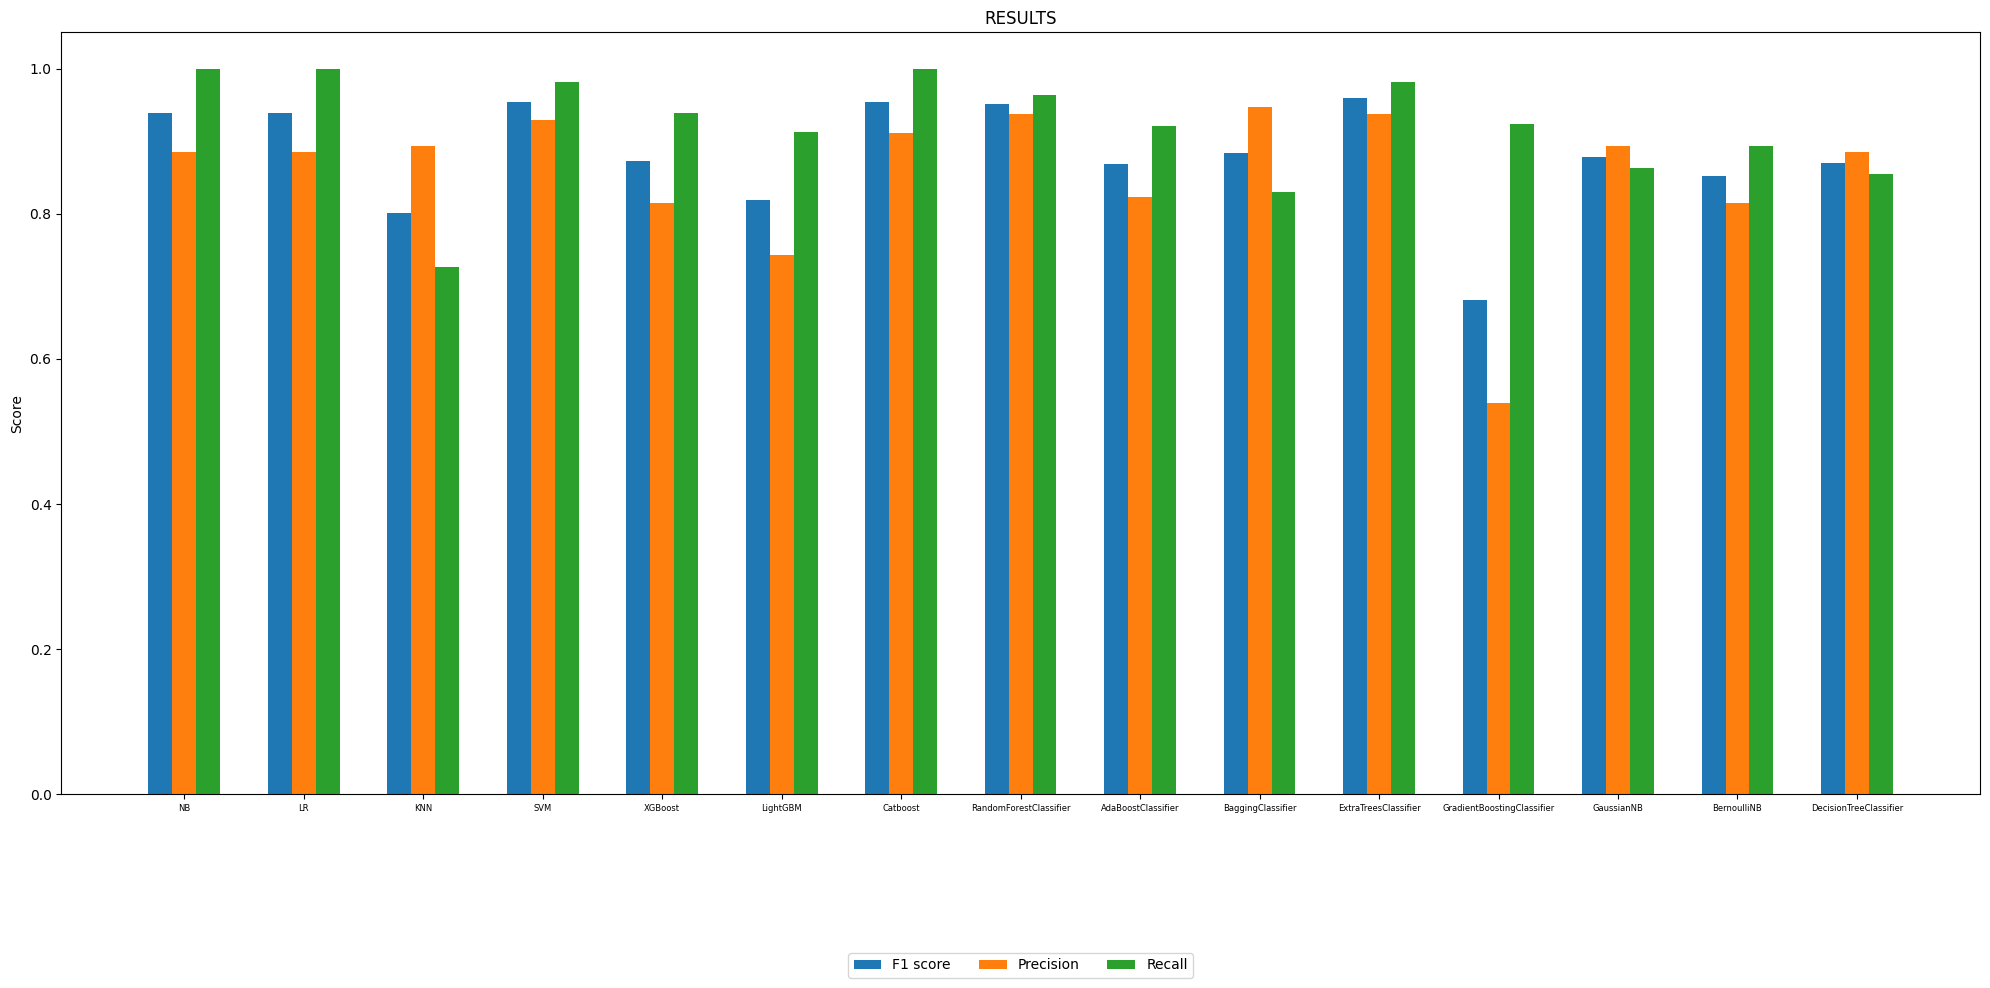

                                  f1 precision    recall  accuracy  \
NB                          0.938967  0.884956       1.0  0.973684   
LR                          0.938967  0.884956       1.0  0.973684   
KNN                         0.801587  0.893805  0.726619  0.898785   
SVM                         0.954545  0.929204  0.981308  0.979757   
XGBoost                     0.872038  0.814159  0.938776  0.945344   
LightGBM                    0.819512  0.743363  0.913043  0.925101   
Catboost                    0.953704  0.911504       1.0  0.979757   
RandomForestClassifier      0.950673  0.938053  0.963636  0.977733   
AdaBoostClassifier          0.869159  0.823009  0.920792   0.94332   
BaggingClassifier           0.884298  0.946903  0.829457   0.94332   
ExtraTreesClassifier        0.959276  0.938053  0.981481  0.981781   
GradientBoostingClassifier  0.681564  0.539823  0.924242  0.884615   
GaussianNB                  0.878261  0.893805  0.863248   0.94332   
BernoulliNB         

In [80]:
train_baselines(
    list(range(1)),
    datasets=["csv"],
    task_name="TrainBaselines",
    test_set = "test"
)

Training LLMs:

In [81]:
class EvalOnTrainCallback(TrainerCallback):
    """Custom callback to evaluate on the training set during training."""

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_train = copy.deepcopy(control)
            self._trainer.evaluate(
                eval_dataset=self._trainer.train_dataset, metric_key_prefix="train"
            )
            return control_train

In [82]:
def get_trainer(model, traindict, testdict, tokenizer=None):
    """
    Description: Creates a Hugging Face Trainer object for a given model and datasets.

    # Args:
        model: The Hugging Face model to train.
        traindict: A Hugging Face DatasetDict containing the training data.
        testdict: A Hugging Face DatasetDict containing the test data.
        tokenizer (optional): The tokenizer associated with the model.

    Returns:
        Trainer: A Hugging Face Trainer object configured for training.

    # Example:

    >>> trainer = get_trainer(model, train_dataset, test_dataset, tokenizer)
    """

    def compute_metrics(y_pred):
        """Computer metrics during training."""
        logits, labels = y_pred
        predictions = np.argmax(logits, axis=-1)
        return evaluate.load("f1").compute(
            predictions=predictions, references=labels, average="macro"
        )

    if type(model).__name__ == "SetFitModel":
        trainer = SetFitTrainer(
            model=model,
            train_dataset=traindict,
            eval_dataset=testdict,
            loss_class=CosineSimilarityLoss,
            metric="f1",
            batch_size=4,
            num_iterations=1,
            num_epochs=1,
        )
        return trainer

    elif "T5" in type(model).__name__ or "FLAN" in type(model).__name__:

        def compute_metrics_t5(y_pred, verbose=0):
            """Computer metrics during training for T5-like models."""
            predictions, labels = y_pred

            predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

            # Replace -100 with pad_token_id to decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            predictions = [
                1 if "spam" in predictions[i] else 0 for i in range(len(predictions))
            ]
            labels = [1 if "spam" in labels[i] else 0 for i in range(len(labels))]

            result = evaluate.load("f1").compute(
                predictions=predictions, references=labels, average="macro"
            )
            return result

        data_collator = DataCollatorForSeq2Seq(
            tokenizer, model=model, label_pad_token_id=-100, pad_to_multiple_of=8
        )

        training_args = Seq2SeqTrainingArguments(
            output_dir="experiments",
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            learning_rate=1,
            num_train_epochs=1,
            predict_with_generate=True,
            fp16=False,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            save_total_limit=2,
        )

        trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            train_dataset=traindict,
            eval_dataset=testdict,
            data_collator=data_collator,
            compute_metrics=compute_metrics_t5,
        )
        trainer.add_callback(EvalOnTrainCallback(trainer))
        return trainer

    else:
        training_args = TrainingArguments(
            output_dir="experiments",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=4,
            learning_rate=1,
            num_train_epochs=1,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            save_total_limit=1,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=traindict,
            eval_dataset=testdict,
            compute_metrics=compute_metrics,
        )
        trainer.add_callback(EvalOnTrainCallback(trainer))
        return trainer

In [83]:
def predict(trainer: transformers, model, dataset, tokenizer=None)-> list:
    """
    Description: Generates predictions on a given dataset using a trained model and trainer.

    # Args:
        trainer: The Hugging Face Trainer object used for training.
        model: The trained Hugging Face model.
        dataset: A Dataset containing the data for prediction.
        tokenizer (optional): The tokenizer associated with the model.

    Returns:
        list: A list of predictions for each example in the dataset.

    # Example:

    >>> predictions = predict(trainer, model, test_dataset, tokenizer)
    """
    if type(model).__name__ == "SetFitModel":
        return model(dataset["text"])

    elif "T5" in type(model).__name__:
        predictions = trainer.predict(dataset)
        predictions = tokenizer.batch_decode(
            predictions.predictions, skip_special_tokens=True
        )
        print(predictions)
        
        predictions = [
            0 if predictions[i] == "ham" else 1 for i in range(len(predictions))]

        print(predictions)
        return predictions

    else:
        return trainer.predict(dataset).predictions.argmax(axis=-1)

In [84]:
def train_llms(seeds, datasets, task_name, test_set="test"):
    """
    Description: Trains multiple LLMs on different seeds and datasets for a specific task.

    # Args:
        seeds (list[int]): A list of random seeds for training different models.
        datasets (list[datasets.DatasetDict]): A list of DatasetDicts, each containing train and test data.
        task_name (str): The name of the task for which the models are being trained.
        test_set (str, optional): The name of the test set within the DatasetDict. Defaults to "test".

    Returns:
        None

    # Example:

    >>> train_llms(
    list(range(1)),
    datasets=["asd"],
    task_name="LLMTrainCheck")
    """
    for seed in list(seeds):
        set_seed(seed)

        for dataset_name in datasets:
            print(dataset_name)
            # Get metrics
            scores = pd.DataFrame(
                index=list(LLMS.keys()),
                columns=list(SCORING.keys()) + ["training_time", "inference_time"],
            )

            df = get_dataset(dataset_name)
            _, dataset = train_val_test_split(
                    df, train_size=0.7, has_val=True
                )
            
            print(dataset)
            print("split succeded=)")
    
            # Name experiment
            experiment = (
                f"llm_{test_set}_train_seed_{seed}"
            )
    
            # Train, evaluate, test
            for model_name, (model, tokenizer) in LLMS.items():
                tokenized_dataset = tokenize(dataset, tokenizer)
                trainer = get_trainer(model, tokenized_dataset['train'], tokenized_dataset['val'], tokenizer)
                #print(trainer.args)
                # Train model
                start = time.time()
                print("beginning of train")
                train_result = trainer.train()
                end = time.time()
                print(f"train ended after: {end}")
                scores.loc[model_name, "training_time"] = end - start
                if "SetFit" not in model_name:
                    log = pd.DataFrame(trainer.state.log_history)
                    log.to_csv(f"outputs/csv/loss_{model_name}_{experiment}.csv")
                    plot_loss(experiment, "EMAIL spam check", model_name)
    
                # Test model
                start = time.time()
                print(tokenized_dataset[test_set])

                predictions = predict(
                    trainer, model, tokenized_dataset[test_set], tokenizer
                )
                end = time.time()
                print(predictions)
                print(dataset[test_set]["label"])
    
                for score_name, score_fn in SCORING.items():
                    scores.loc[model_name][score_name] = score_fn(
                        dataset[test_set]["label"], predictions
                    )
    
                scores.loc[model_name]["inference_time"] = end - start
                save_scores(
                    task_name, experiment, model_name, scores.loc[model_name].to_dict()
                )
    
            # Display scores
            plot_scores(task_name, experiment, task_name)
            print(scores)
    

csv
DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'label', 'text', '__index_level_0__'],
        num_rows: 2305
    })
    val: Dataset({
        features: ['Unnamed: 0', 'label', 'text', '__index_level_0__'],
        num_rows: 495
    })
    test: Dataset({
        features: ['Unnamed: 0', 'label', 'text', '__index_level_0__'],
        num_rows: 494
    })
})
split succeded=)


Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

beginning of train


train ended after: 1715503513.7653685


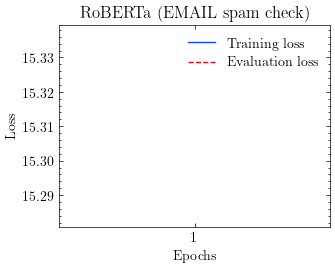

Dataset({
    features: ['Unnamed: 0', 'label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 494
})


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

beginning of train


***** Running training *****
  Num unique pairs = 4610
  Batch size = 4
  Num epochs = 1
  Total optimization steps = 1153


train ended after: 1715504031.2726161
Dataset({
    features: ['Unnamed: 0', 'label', 'text', '__index_level_0__'],
    num_rows: 494
})
tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

beginning of train


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


train ended after: 1715505572.6302726


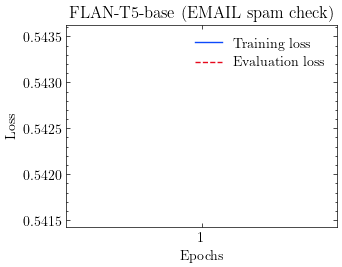

Dataset({
    features: ['Unnamed: 0', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 494
})


['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham'

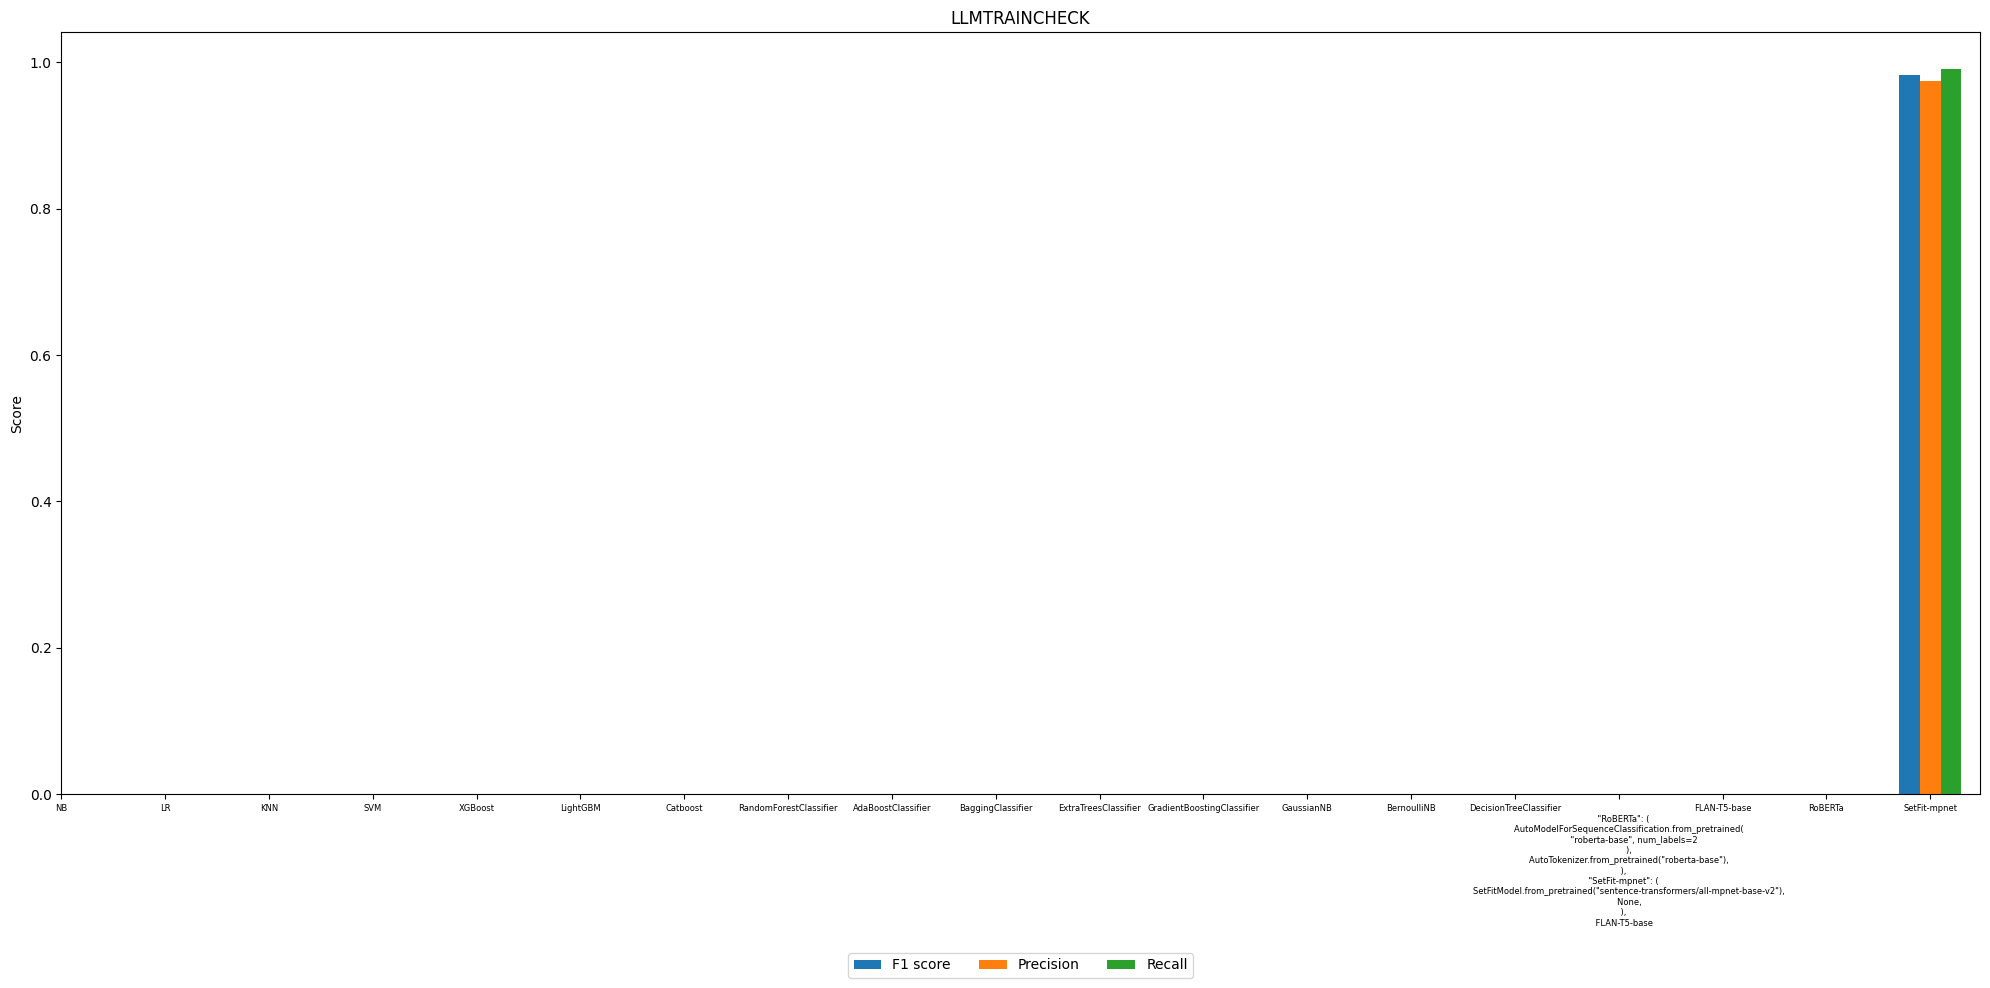

                    f1 precision   recall  accuracy training_time  \
RoBERTa            0.0       0.0      0.0  0.771255    234.616727   
SetFit-mpnet  0.982456  0.973913  0.99115  0.991903    503.331551   
FLAN-T5-base       0.0       0.0      0.0  0.771255   1519.634007   

             inference_time  
RoBERTa           12.309372  
SetFit-mpnet      17.149328  
FLAN-T5-base      29.531539  


In [85]:
train_llms(
    list(range(1)),
    datasets=["csv"],
    task_name="LLMTrainCheck",
)